In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os

#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## The Model

### It's Outline

The model will have three input features: $\log (M_{\text{stellar}}), \log (\frac{M_{\text{dust}}}{M_{\text{stellar}}}),$ and $\sin (\theta)$.

$M_{\text{stellar}}$ is stellar mass, $M_{\text{dust}}$ is dust mass, and $\theta$ is inclination. The logs of the first two, the sine of the inclination, and other parameters that I won't account for here, are written to a parameter file for the SKIRT model to generate a data cube out of. The output of the SKIRT model, so to speak, is an array of values for sersic index, $n$, flux, $f$, and half-light radius, $r$. All three arrays are functions of $\lambda$.

Our model will therefore have three branches, instead of two: as when I investigated normalisation in week 6. I'd have initially had one output feature per output *branch*. Like in normalisation, the reason was because two inputs yielded two outputs. In this case, though, three inputs yield three *arrays* of outputs - each of size 113. Each output layer has 113 features for that reason.

Version 3 of this notebook will have three input features, but only one output branch of 113 features. The intention behind this is to observe how accurate the model will be in predicting $r, f,$ and $n$ individually, rather than all three in one go: like I'm doing here.

In [2]:
class TripleOutputBNN(nn.Module):
    #generate docstring
    """
    This is a class for a Bayesian Neural Network with 3 outputs.
    Attributes:
        no_of_neurones (int): number of neurones in the hidden layer.
        dropout_prob (float): dropout probability.
    """

    def __init__(self, no_of_neurones, dropout_prob):
        """
        The constructor for TripleOutputBNN class.
        
        Parameters:
            no_of_neurones (int): number of neurones in the hidden layer.
            dropout_prob (float): dropout probability.
        """
        
        super(TripleOutputBNN, self).__init__()
        self.shared_layer = nn.Sequential( #this is the input layer
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        self.output_layer_y0 = nn.Sequential( #this is the output layer for y0
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=113)
        )
        self.output_layer_y1 = nn.Sequential( #this is the output layer for y1
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=113)
        )
        self.output_layer_y2 = nn.Sequential( #this is the output layer for y2
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=113)
        )


    def forward(self, x): #this is the forward pass, run automatically when you call the model
        """
        This function performs the forward pass.
        Parameters:
            x (tensor): input tensor.
        
        Returns:
            y0 (tensor): output tensor for y0.
            y1 (tensor): output tensor for y1.
            y2 (tensor): output tensor for y2.
        """

        shared = self.shared_layer(x)
        y0 = self.output_layer_y0(shared)
        y1 = self.output_layer_y1(shared)
        y2 = self.output_layer_y2(shared)
        return y0, y1, y2


### Initialising the Model

In [3]:
def initialise_model(no_of_neurones: int, dropout_prob: float, lr: float = 0.01) -> tuple:
    """
    Initialise the DualOutputBNN model with its loss functions and optimizer.

    Parameters:
    - no_of_neurones (int): Number of neurons in the hidden layer.
    - dropout_prob (float): Dropout probability.
    - lr (float): Learning rate for the optimizer. Default is 0.01.

    Returns:
    - A tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    """

    model = TripleOutputBNN(no_of_neurones, dropout_prob).to(device)

    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model, mse_loss, kl_loss, kl_weight, optimizer


### Training the Model

In [4]:
def train_model(model_attributes, input_train, output_train, epochs: int):
    """
    Train the model.

    Parameters:
    - model_attributes (tuple): Tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    - input_train (tensor): Input tensor for training.
    - output_train (tensor): Output tensor for training.
    - epochs (int): Number of epochs to train the model.

    Returns:
    - The trained model.
    """

    model, mse_loss, kl_loss, kl_weight, optimizer = model_attributes
    model = model.train()

    for _ in range(epochs): 
        n_pred, f_pred, r_pred = model(input_train)

        n_mse = mse_loss(torch.unsqueeze(torch.Tensor(n_pred), dim = 2), torch.unsqueeze(torch.Tensor(output_train[:,0]), dim=2))
        f_mse = mse_loss(torch.unsqueeze(torch.Tensor(f_pred), dim = 2), torch.unsqueeze(torch.Tensor(output_train[:,1]), dim=2))
        r_mse = mse_loss(torch.unsqueeze(torch.Tensor(r_pred), dim = 2), torch.unsqueeze(torch.Tensor(output_train[:,2]), dim=2))

        kl = kl_loss(model)
        n_cost, f_cost, r_cost = n_mse + kl_weight * kl, f_mse + kl_weight * kl, r_mse + kl_weight * kl
        cost = n_cost + f_cost + r_cost

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    print(f"- Cost: {cost.item():.3f}")

    return model


### Testing the Model

In [5]:
def test_model(model, model_attributes, input_test, output_test):
    """
    Test the model.

    Parameters:
    - model (nn.Module): Trained model.
    - model_attributes (tuple): Tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    - input_test (tensor): Input tensor for testing.
    - output_test (tensor): Output tensor for testing.

    Returns:
    - mean_n_results (tensor): Mean of the predictions for y0.
    - std_n_results (tensor): Standard deviation of the predictions for y0.
    - mean_f_results (tensor): Mean of the predictions for y1.
    - std_f_results (tensor): Standard deviation of the predictions for y1.
    - mean_r_results (tensor): Mean of the predictions for y2.
    - std_r_results (tensor): Standard deviation of the predictions for y2.
    """

    mse_loss, kl_loss, kl_weight, optimizer = model_attributes[1:]

    #producing predictions of model of testing data, as well as mean and standard deviation of predictions
    model = model.eval().cpu()
    input_test = input_test.cpu()
    output_test = output_test.cpu()

    n_pred = np.array([model(input_test)[0].detach().numpy() for _ in range(500)]).T
    f_pred = np.array([model(input_test)[1].detach().numpy() for _ in range(500)]).T
    r_pred = np.array([model(input_test)[2].detach().numpy() for _ in range(500)]).T

    #for each prediction of row, find mean and standard deviation
    mean_n_results = np.mean(n_pred, axis = 2)
    std_n_results = np.std(n_pred, axis = 2)
    mean_f_results = np.mean(f_pred, axis = 2)
    std_f_results = np.std(f_pred, axis = 2)
    mean_r_results = np.mean(r_pred, axis = 2)
    std_r_results = np.std(r_pred, axis = 2)
    
    #find the cost of the model
    n_mse = mse_loss(torch.unsqueeze(torch.Tensor(mean_n_results), dim = 2), torch.unsqueeze(torch.Tensor(output_test[:,0].T), dim=2))
    f_mse = mse_loss(torch.unsqueeze(torch.Tensor(mean_f_results), dim = 2), torch.unsqueeze(torch.Tensor(output_test[:,1].T), dim=2))
    r_mse = mse_loss(torch.unsqueeze(torch.Tensor(mean_r_results), dim = 2), torch.unsqueeze(torch.Tensor(output_test[:,2].T), dim=2))

    kl = kl_loss(model)
    n_cost, f_cost, r_cost = n_mse + kl_weight * kl, f_mse + kl_weight * kl, r_mse + kl_weight * kl
    cost = n_cost + f_cost + r_cost

    print(f"- Cost: {cost.item():.3f}")

    return mean_n_results, std_n_results, mean_f_results, std_f_results, mean_r_results, std_r_results


## The Data Processing

### Reading Input Parameters

This is code from the radiative transfer library. Read the docstring in the function for more information. Read the parameters text files in the filepath argument in the function below to see why the function is of the nature that it is.

In [6]:
def read_params(filename: str, filepath: str = '../../data/radiative_transfer/input/'):
    """
    Read the parameters from the input file.

    Parameters:
    - filename (str): Name of the input file.
    - filepath (str): Path to the input file. Default is '../../data/radiative_transfer/input/'.

    Returns:
    - table (dict): Dictionary containing the parameters.
    """

    lines = open(filepath+filename, 'r').readlines()

    keys = []
    values = []
    for i in range(len(lines)):

        line_i = lines[i]
        line1 = line_i.split('\n')[0]
        line2 = line1.split('#')[0]
        line3 = line2.split('=')
        line4 = []
        for j in range(len(line3)):
            line4.append( line3[j].strip(' ') )

        if len(line4) == 2:
            keys.append(line4[0])
            line5 = line4[1].split(', ')
            line5 = np.array(line5).astype(float)
            if len(line5) == 1 and line4[0]!='theta':
                line5 = line5[0]
            values.append(line5)

    table = dict(zip(keys, values) )
    return table


### Reading Output Files

The SKIRT model outputs a h5 file. In this file is compiled the arrays of $r, f,$ and $n$ against $\lambda$: for each inclination. When we ran the SKIRT model, we had 20 inclinations. We have six h5 files in the directory indicated by the filepath argument of the function below. The rest is as indicated in said function's docstring.

In [7]:
def read_h5_file(filename: str, data, thetas, log_mstar, log_mdust_over_mstar, filepath: str = '../../data/radiative_transfer/output/'):
    """
    Read the output file.

    Parameters:
    - filename (str): Name of the output file.
    - data (pd.DataFrame): DataFrame containing the data.
    - thetas (list): List of viewing angles.
    - log_mstar (float): log of stellar mass.
    - log_mdust_over_mstar (float): log of dust mass over stellar mass.
    - filepath (str): Path to the output file. Default is '../../data/radiative_transfer/output/'.

    Returns:
    - wvl (np.array): Rest-frame wavelength [micron].
    - data (pd.DataFrame): DataFrame containing the data.
    """

    normalise = lambda x: (x - np.mean(x)) / np.std(x)

    filepath += filename 
    print(filepath)

    # Finding hdf keys
    hdf_keys = np.array([])
    with pd.HDFStore(filepath, 'r') as hdf:
        hdf_keys = np.append(hdf_keys, hdf.keys())

    for i in range(len(hdf_keys)):

        table = pd.read_hdf(filepath, hdf_keys[i]) # Face-on view
        wvl = table['wvl'].to_numpy(dtype=np.float64) # rest-frame wavelength [micron]
        flux = table['flux'].to_numpy(dtype=np.float64) # flux [W/m^2]
        r = table['r'].to_numpy(dtype=np.float64) # half-light radius [kpc]
        n = table['n'].to_numpy(dtype=np.float64) # Sersic index

        flux, r, n = normalise(flux), normalise(r), normalise(n)

        data = pd.concat([data, pd.DataFrame({"log_mstar": log_mstar, "log_mdust_over_mstar": log_mdust_over_mstar, "theta": thetas[i], "n":[n], "flux":[flux], "r":[r]})], ignore_index=True)

    return wvl, data.reset_index(drop=True)


### Reading Input Files

This just gives me the input values I'm going to feed the model.

In [8]:
def read_parameter_files(filenames: list, filepath: str = "../../data/radiative_transfer/input/"):
    """
    Read the parameter files.

    Parameters:
    - filenames (list): List of filenames.
    - filepath (str): Path to the parameter files. Default is '../../data/radiative_transfer/input/'.

    Returns:
    - list_log_mstar (np.array): Array of log of stellar mass.
    - list_log_mdust_over_mstar (np.array): Array of log of dust mass over stellar mass.
    - list_theta (np.array): Array of viewing angles.
    """

    list_log_mstar = np.array([])
    list_log_mdust = np.array([])
    list_theta = np.array([])

    for filename in filenames:
        table = read_params(filename, filepath)
        list_log_mstar = np.append(list_log_mstar, table['logMstar'])
        list_log_mdust = np.append(list_log_mdust, table['logMdust'])
        list_theta = np.append(list_theta, table['theta'])

    list_log_mdust_over_mstar = list_log_mdust - list_log_mstar

    return list_log_mstar, list_log_mdust_over_mstar, list_theta


### Compiling the Dataset

In [9]:
def generate_dataset(data, params, files):
    """
    Generate the dataset.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.
    - params (list): List of parameter files.
    - files (list): List of output files.

    Returns:
    - wavelength (np.array): Rest-frame wavelength [micron].
    - data (pd.DataFrame): DataFrame containing the data.
    """

    list_log_mstar, list_log_mdust_over_mstar, list_theta = read_parameter_files(params)

    for i in range(len(files)):
        wavelength, data = read_h5_file(files[i], data, np.sin(list_theta), list_log_mstar[i], list_log_mdust_over_mstar[i])

    return wavelength, data


In [10]:
#obtaining logs of stellar mass, and ratio of dust to stellar mass
parameter_files = [file for file in os.listdir("../../data/radiative_transfer/input/") if file.startswith("parameters")]
h5_files = [file for file in os.listdir("../../data/radiative_transfer/output/") if file.startswith("data")]

wavelength, h5_data = generate_dataset(pd.DataFrame(columns=["log_mstar", "log_mdust_over_mstar", "theta", "n", "flux", "r"]), parameter_files, h5_files)


../../data/radiative_transfer/output/data1.h5


C:\Users\joshu\AppData\Local\Temp\ipykernel_24720\2748709934.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame({"log_mstar": log_mstar, "log_mdust_over_mstar": log_mdust_over_mstar, "theta": thetas[i], "n":[n], "flux":[flux], "r":[r]})], ignore_index=True)


../../data/radiative_transfer/output/data2.h5
../../data/radiative_transfer/output/data3.h5
../../data/radiative_transfer/output/data4.h5
../../data/radiative_transfer/output/data5.h5
../../data/radiative_transfer/output/data6.h5


## The Results

### Splitting the Dataset

In [11]:
def convert_to_tensor(data):
    """
    Convert the DataFrame to a tensor.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.

    Returns:
    - data (tensor): Tensor containing the data.
    """

    data = data.applymap(np.array)
    stacked_input_arrays = np.stack(data.apply(lambda row: np.stack(row, axis=0), axis=1).to_numpy())
    data = torch.Tensor(stacked_input_arrays).to(device)

    return data


In [12]:
#split h5_data into training and testing sets
train, test = train_test_split(h5_data, test_size=0.2, random_state=42)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

#split training and testing sets into inputs and outputs
train_inputs, train_outputs = train[["log_mstar", "log_mdust_over_mstar", "theta"]], train[["n", "flux", "r"]]
test_inputs, test_outputs = test[["log_mstar", "log_mdust_over_mstar", "theta"]], test[["n", "flux", "r"]]

#convert training and testing data into numpy arrays
train_inputs, test_inputs = train_inputs.to_numpy(), test_inputs.to_numpy()
train_inputs, test_inputs = torch.Tensor(train_inputs).to(device), torch.Tensor(test_inputs).to(device)

train_outputs, test_outputs = convert_to_tensor(train_outputs).to(device), convert_to_tensor(test_outputs).to(device)


C:\Users\joshu\AppData\Local\Temp\ipykernel_24720\1086047279.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(np.array)


### Setting up the Model

In [13]:
#initialise, train, and test the model
model_attributes = initialise_model(1000, 0.3)
model = train_model(model_attributes, train_inputs, train_outputs, 2000)


- Cost: 0.289


In [14]:
mean_n_results, std_n_results, mean_f_results, std_f_results, mean_r_results, std_r_results = test_model(model, model_attributes, input_test=test_inputs, output_test=test_outputs)
test_outputs = test_outputs.cpu().numpy()


- Cost: 0.322


### Plotting the Model's Predictions

Hopefully, you'll see from the model's predicted flux values the motivation behind processing each output separately. 

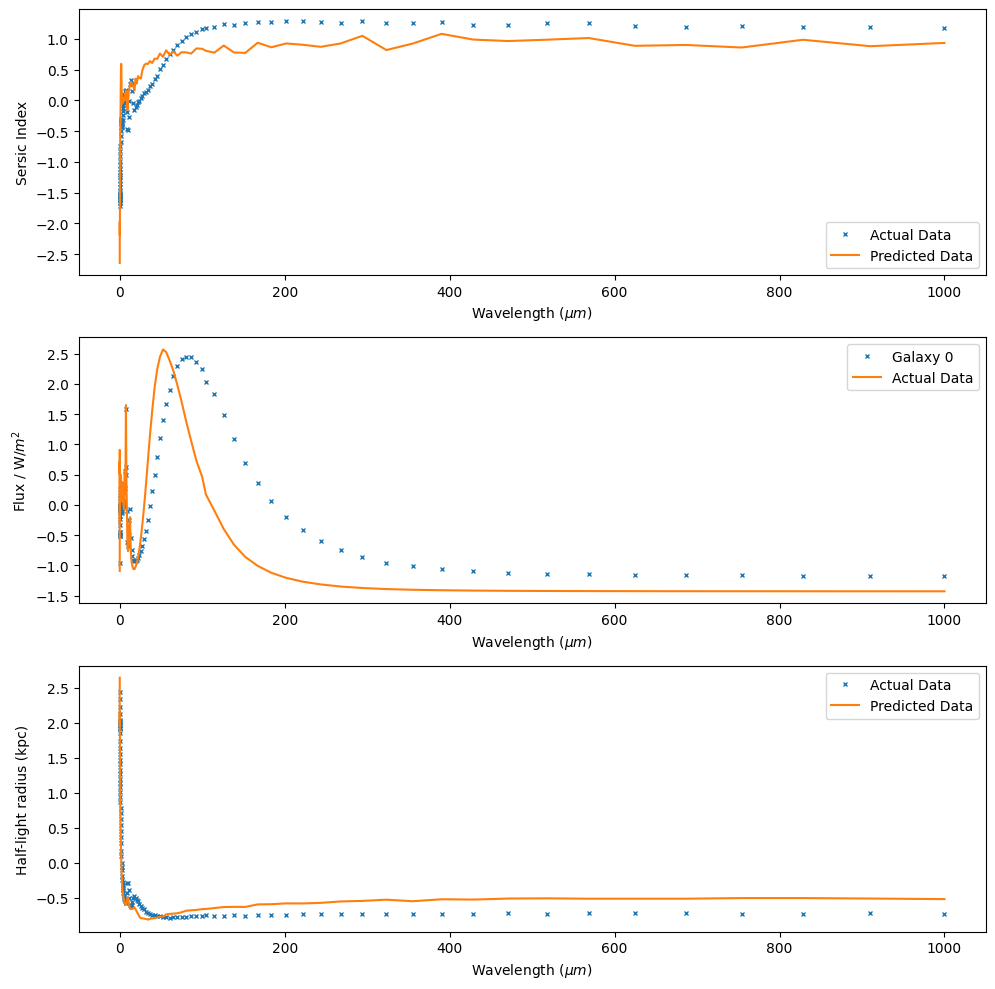

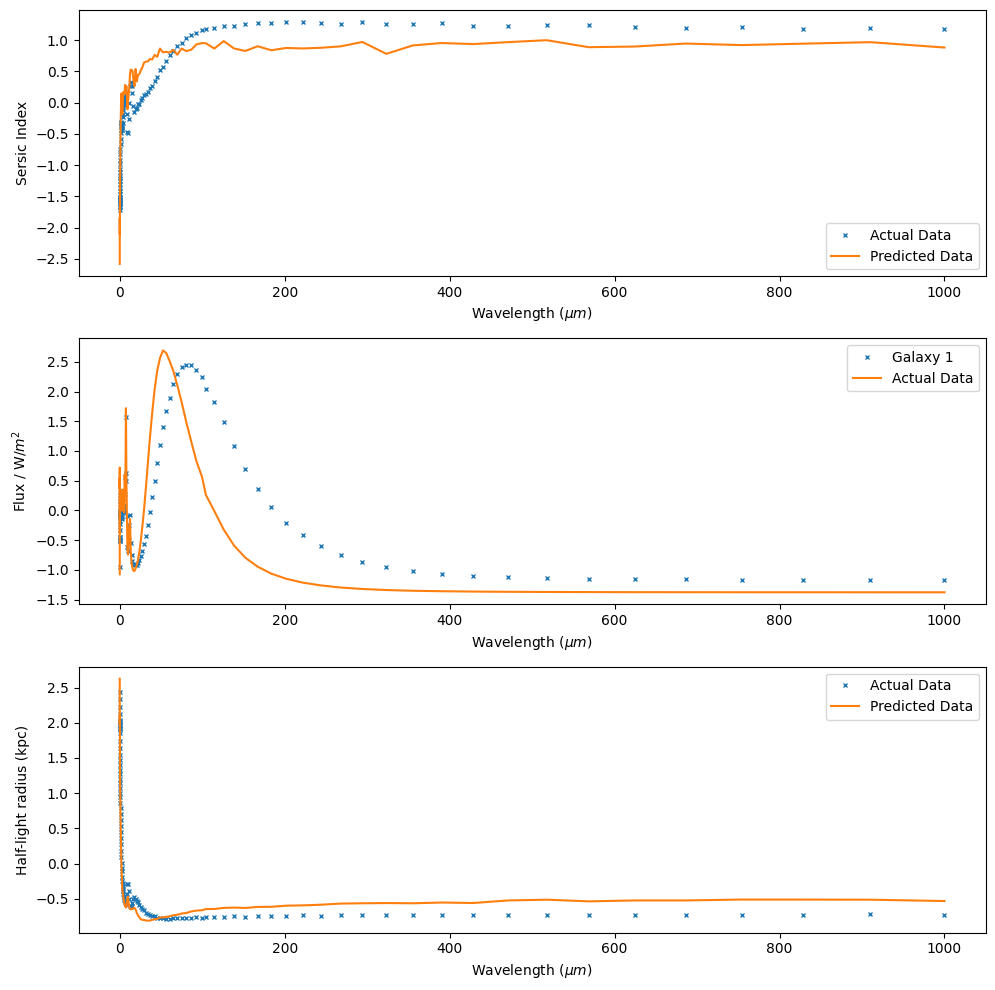

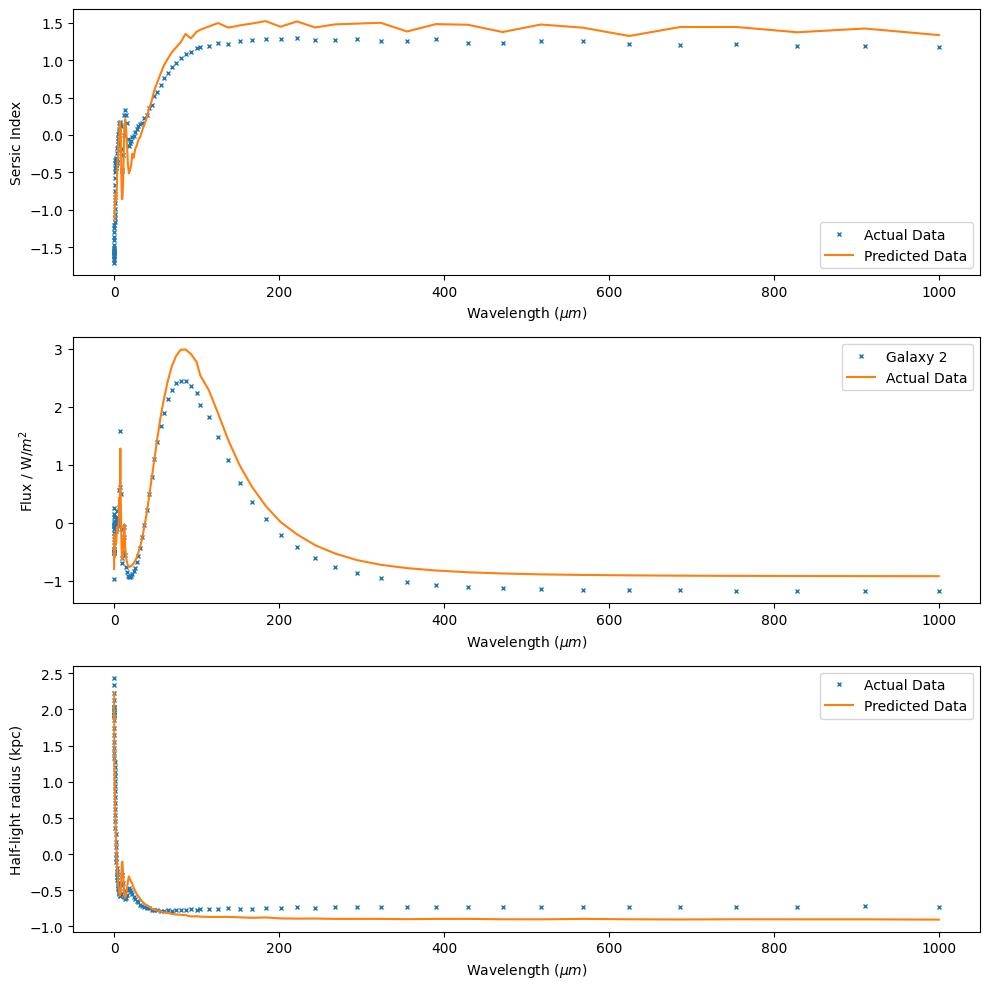

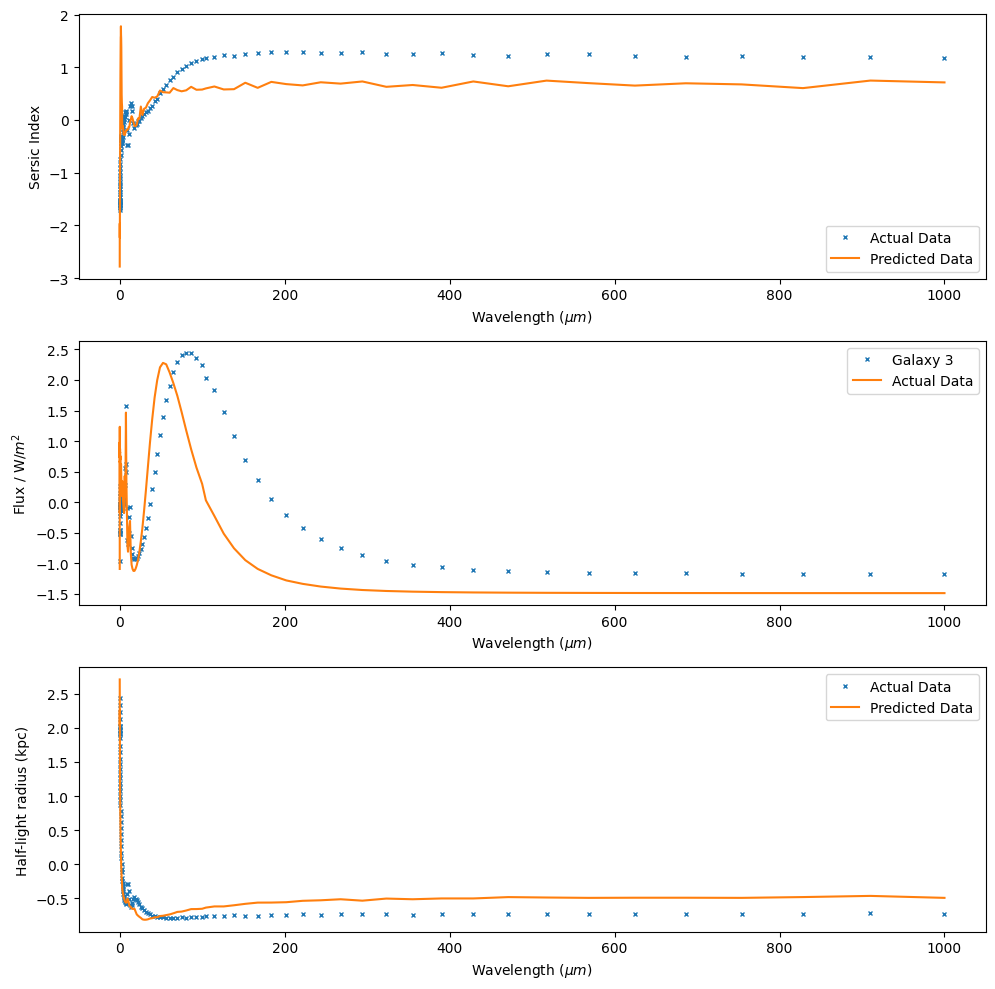

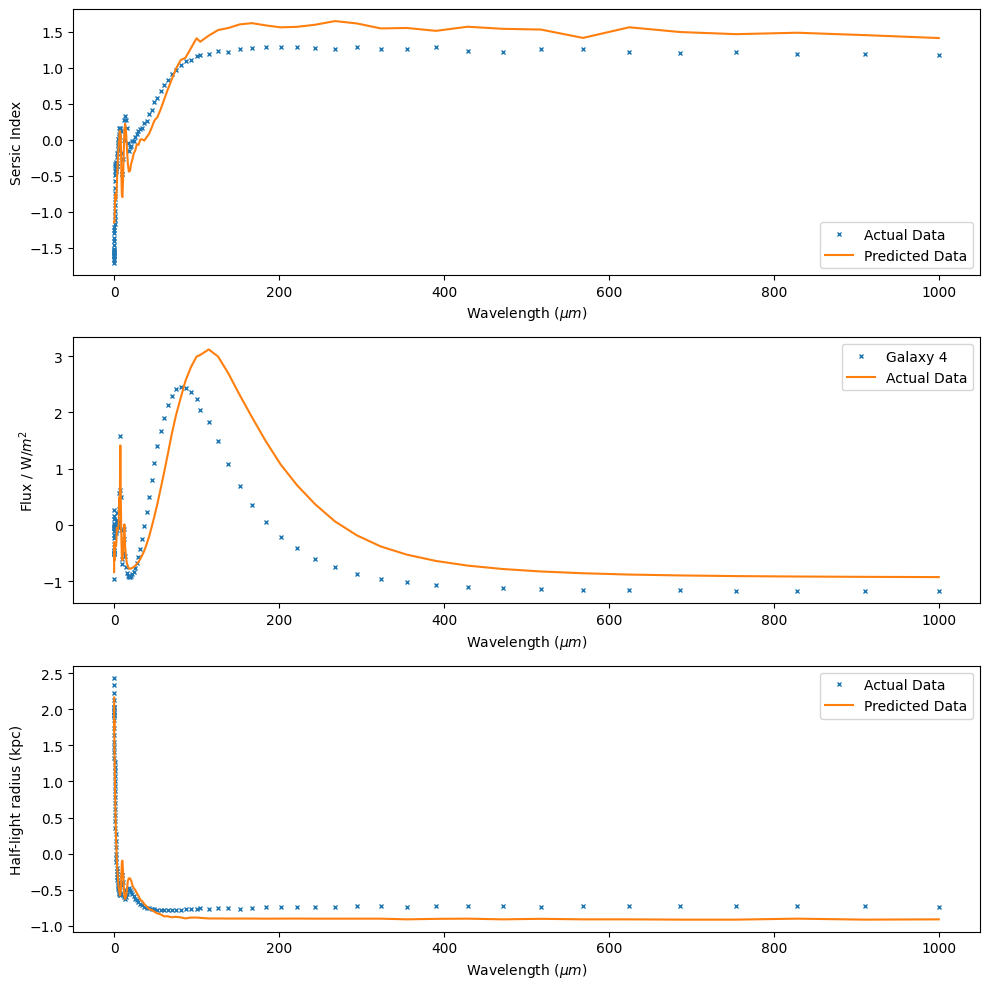

In [15]:
#plot the predicted sersic index, flux, and half-radius against wavelength on separate axes, but same figure: for the first 5 galaxies
for i in range(5):
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    axs[0].plot(wavelength, mean_n_results[:,i], label=f"Actual Data", ls="None", marker="x", markersize=3)
    axs[0].plot(wavelength, test_outputs[i, 0], label=f"Predicted Data")
    axs[0].set_xlabel("Wavelength ($\\mu m$)")
    axs[0].set_ylabel("Sersic Index")
    # axs[0].set_xscale("log")
    axs[0].legend()

    axs[1].plot(wavelength, mean_f_results[:,i], label=f"Galaxy {i}", ls="None", marker="x", markersize=3)
    axs[1].plot(wavelength, test_outputs[i, 1], label=f"Actual Data")
    axs[1].set_xlabel("Wavelength ($\\mu m$)")
    axs[1].set_ylabel("Flux / W/$m^2$")
    # axs[1].set_xscale("log")
    axs[1].legend()

    axs[2].plot(wavelength, mean_r_results[:,i], label=f"Actual Data", ls="None", marker="x", markersize=3)
    axs[2].plot(wavelength, test_outputs[i, 2], label=f"Predicted Data")
    axs[2].set_xlabel("Wavelength ($\\mu m$)")
    axs[2].set_ylabel("Half-light radius (kpc)")
    # axs[2].set_xscale("log")
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()
    plt.close()
